
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).

- a)	Entrenar un modelo de deep learning que no utilice embeddings y que no emplee el `user_id` ni el `product_id`.
- b)	Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.
- c)	Grafique las curvas de la loss function en función de las epochs de cada modelo y comente lo necesario.
- d) Compare el score de cada modelo.

In [70]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from miceforest import ImputationKernel
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader

In [71]:
# Read dataset
df_blacks = pd.read_csv('./data/dataset_black_sales.csv')

### Data preparation

In [72]:
# Check for dataset dimensions
df_blacks.shape

(550068, 12)

In [73]:
# Check the datatype and number features
df_blacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [74]:
df_blacks.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


In [75]:
# Display dataset distribution -- Based on the Data Analysis subject
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12, figsize=(22, 10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

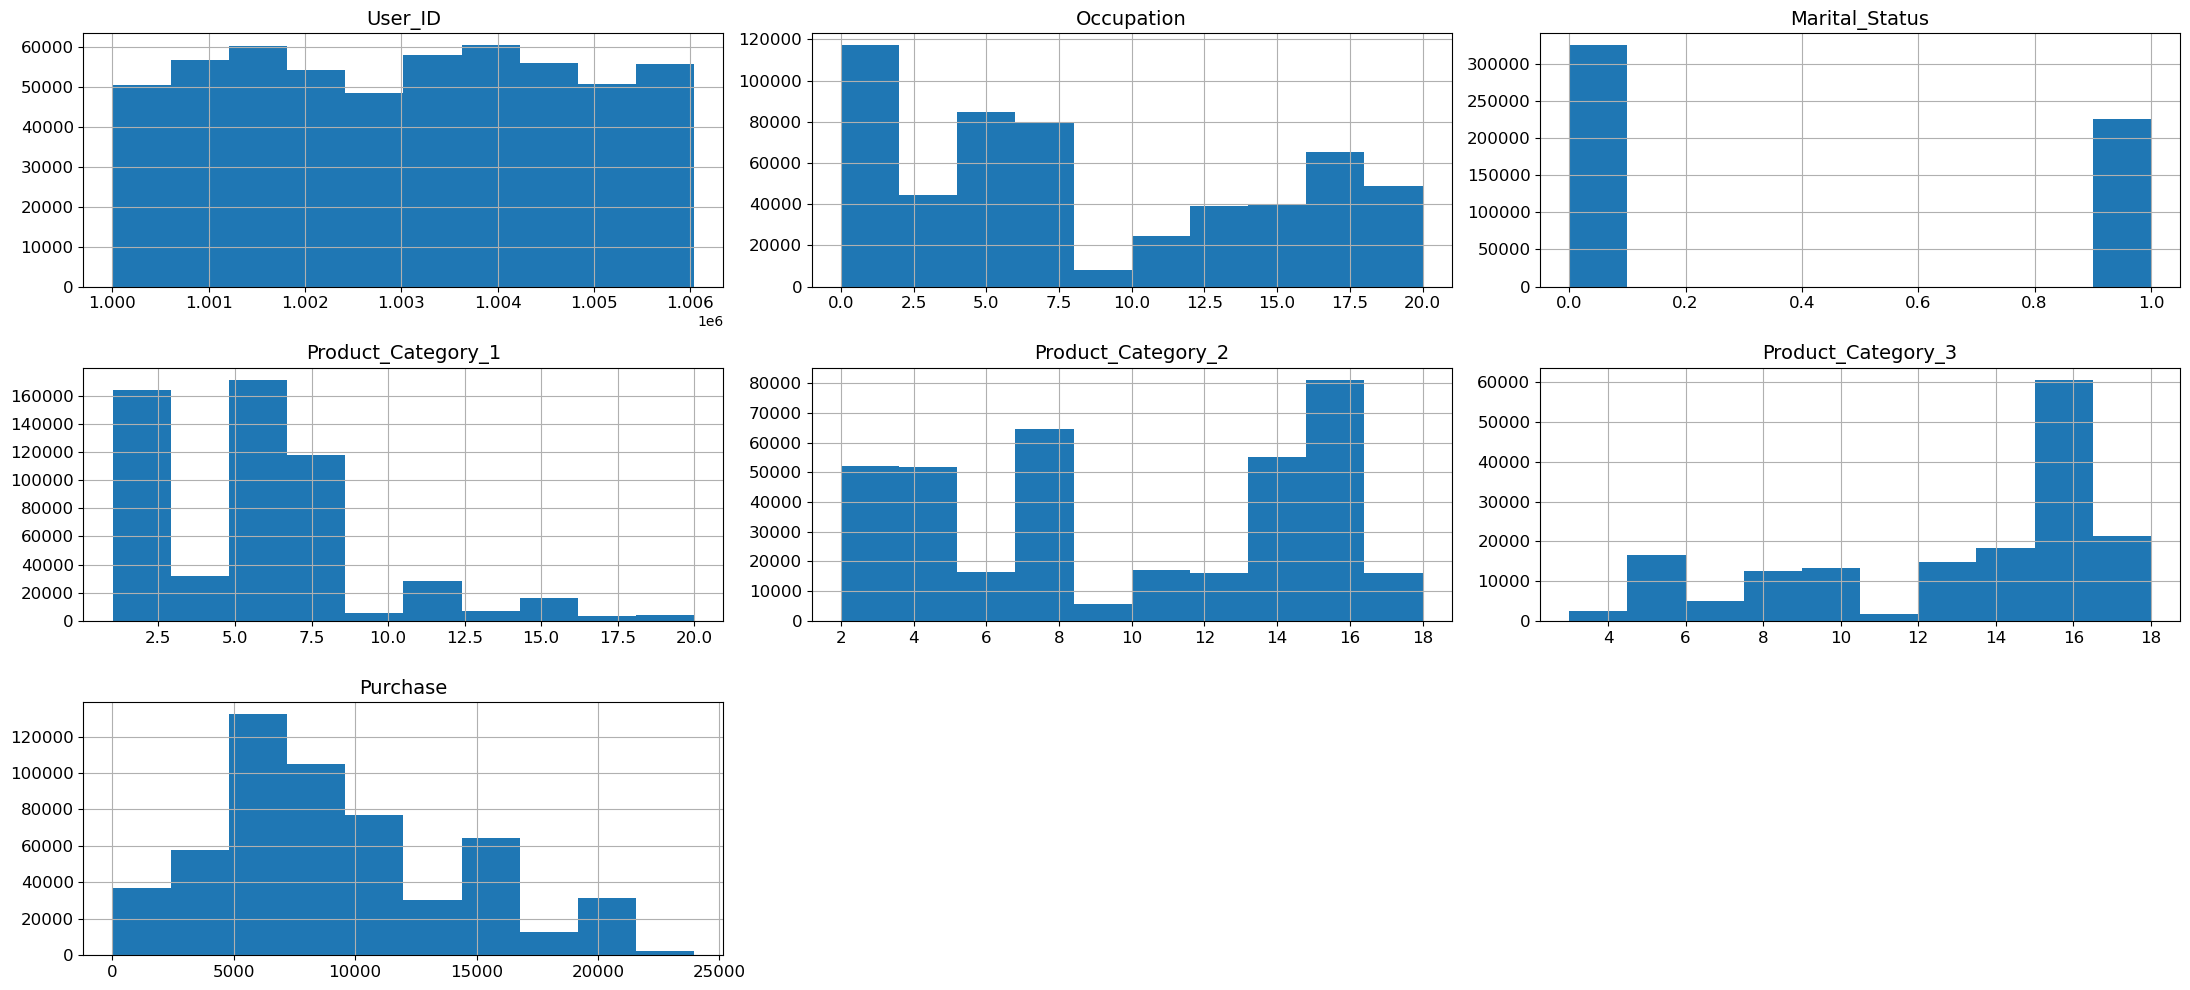

In [76]:
display_dataset_distributions(df_blacks)

In [77]:
# Check unique values
df_blacks.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

/tmp/ipykernel_694/302237164.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_blacks["Purchase"], color='b')


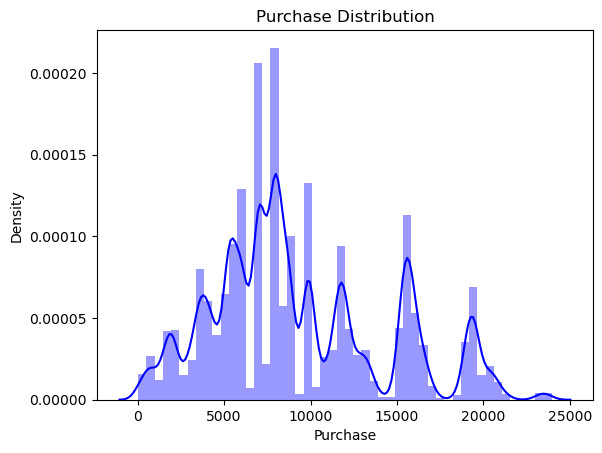

In [78]:
# Check of distribution of target variable
sns.distplot(df_blacks["Purchase"], color='b')
plt.title("Purchase Distribution")
plt.show()

In [79]:
# Check the main statistical  variables of target feature
df_blacks['Purchase'].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

### Encoding categorical variables

In [80]:
df_blacks_modified = pd.get_dummies(
    df_blacks, columns=['Stay_In_Current_City_Years'])

In [81]:
df_blacks_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   User_ID                        550068 non-null  int64  
 1   Product_ID                     550068 non-null  object 
 2   Gender                         550068 non-null  object 
 3   Age                            550068 non-null  object 
 4   Occupation                     550068 non-null  int64  
 5   City_Category                  550068 non-null  object 
 6   Marital_Status                 550068 non-null  int64  
 7   Product_Category_1             550068 non-null  int64  
 8   Product_Category_2             376430 non-null  float64
 9   Product_Category_3             166821 non-null  float64
 10  Purchase                       550068 non-null  int64  
 11  Stay_In_Current_City_Years_0   550068 non-null  uint8  
 12  Stay_In_Current_City_Years_1  

In [82]:
# Label encoding categorical variables
label_encoder = LabelEncoder()

In [83]:
df_blacks_modified['Gender'] = label_encoder.fit_transform(
    df_blacks_modified['Gender'])

In [84]:
df_blacks_modified['Age'] = label_encoder.fit_transform(
    df_blacks_modified['Age'])

In [85]:
df_blacks_modified['City_Category'] = label_encoder.fit_transform(
    df_blacks_modified['City_Category'])

In [86]:
df_blacks_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   User_ID                        550068 non-null  int64  
 1   Product_ID                     550068 non-null  object 
 2   Gender                         550068 non-null  int64  
 3   Age                            550068 non-null  int64  
 4   Occupation                     550068 non-null  int64  
 5   City_Category                  550068 non-null  int64  
 6   Marital_Status                 550068 non-null  int64  
 7   Product_Category_1             550068 non-null  int64  
 8   Product_Category_2             376430 non-null  float64
 9   Product_Category_3             166821 non-null  float64
 10  Purchase                       550068 non-null  int64  
 11  Stay_In_Current_City_Years_0   550068 non-null  uint8  
 12  Stay_In_Current_City_Years_1  

### Missing variables imputation

In [87]:
# Check for NaN  values in target variable
len(df_blacks_modified[df_blacks_modified['Purchase'].isna()])

0

In [88]:
# Check for NaN  values in the other variables
df_blacks_modified = df_blacks_modified[df_blacks_modified['Purchase'].notna()]
(df_blacks_modified.isnull().sum()/len(df_blacks_modified))*100

User_ID                           0.000000
Product_ID                        0.000000
Gender                            0.000000
Age                               0.000000
Occupation                        0.000000
City_Category                     0.000000
Marital_Status                    0.000000
Product_Category_1                0.000000
Product_Category_2               31.566643
Product_Category_3               69.672659
Purchase                          0.000000
Stay_In_Current_City_Years_0      0.000000
Stay_In_Current_City_Years_1      0.000000
Stay_In_Current_City_Years_2      0.000000
Stay_In_Current_City_Years_3      0.000000
Stay_In_Current_City_Years_4+     0.000000
dtype: float64

In [89]:
# Saving USER_ID andd Product_ID for the model with embedding
user_id = df_blacks_modified['User_ID']
product_id = df_blacks_modified['Product_ID']

In [90]:
# Drop User_id, Product_id
df_blacks_preprocessed = df_blacks_modified.drop(
    ['User_ID', 'Product_ID'], axis=1)

In [91]:
# Missing variables imputation with MICE methods
mice_kernel = ImputationKernel(
    data=df_blacks_preprocessed, save_all_iterations=True,
    random_state=42)

In [92]:
mice_kernel.mice(2)
df_blacks_final = mice_kernel.complete_data()
df_blacks_final.head()

,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0,0,10,0,0,3,4.0,5.0,8370,0,0,1,0,0
1,0,0,10,0,0,1,6.0,14.0,15200,0,0,1,0,0
2,0,0,10,0,0,12,14.0,17.0,1422,0,0,1,0,0
3,0,0,10,0,0,12,14.0,17.0,1057,0,0,1,0,0
4,1,6,16,2,0,8,14.0,17.0,7969,0,0,0,0,1


In [93]:
df_blacks_final.isnull().sum()

Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Marital_Status                   0
Product_Category_1               0
Product_Category_2               0
Product_Category_3               0
Purchase                         0
Stay_In_Current_City_Years_0     0
Stay_In_Current_City_Years_1     0
Stay_In_Current_City_Years_2     0
Stay_In_Current_City_Years_3     0
Stay_In_Current_City_Years_4+    0
dtype: int64

In [94]:
df_blacks_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550068 entries, 0 to 550067
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Gender                         550068 non-null  int64  
 1   Age                            550068 non-null  int64  
 2   Occupation                     550068 non-null  int64  
 3   City_Category                  550068 non-null  int64  
 4   Marital_Status                 550068 non-null  int64  
 5   Product_Category_1             550068 non-null  int64  
 6   Product_Category_2             550068 non-null  float64
 7   Product_Category_3             550068 non-null  float64
 8   Purchase                       550068 non-null  int64  
 9   Stay_In_Current_City_Years_0   550068 non-null  uint8  
 10  Stay_In_Current_City_Years_1   550068 non-null  uint8  
 11  Stay_In_Current_City_Years_2   550068 non-null  uint8  
 12  Stay_In_Current_City_Years_3  

In [95]:
df_blacks_final['Purchase_level'] = df_blacks_final['Purchase'].apply(
    lambda q: 0 if q <= 9000 else 1)

In [96]:
# Drop the target value
x = df_blacks_final.drop(['Purchase', 'Purchase_level'], axis=1)
y = df_blacks_final['Purchase_level']

In [97]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550068 entries, 0 to 550067
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Gender                         550068 non-null  int64  
 1   Age                            550068 non-null  int64  
 2   Occupation                     550068 non-null  int64  
 3   City_Category                  550068 non-null  int64  
 4   Marital_Status                 550068 non-null  int64  
 5   Product_Category_1             550068 non-null  int64  
 6   Product_Category_2             550068 non-null  float64
 7   Product_Category_3             550068 non-null  float64
 8   Stay_In_Current_City_Years_0   550068 non-null  uint8  
 9   Stay_In_Current_City_Years_1   550068 non-null  uint8  
 10  Stay_In_Current_City_Years_2   550068 non-null  uint8  
 11  Stay_In_Current_City_Years_3   550068 non-null  uint8  
 12  Stay_In_Current_City_Years_4+ 

### Dataset division

In [98]:
# Normalization
x = x.to_numpy()
y = y.to_numpy()
x_normalized = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))

In [99]:
idx = np.random.permutation(x_normalized.shape[0])
train_idx = idx[0:int(0.80*len(idx))]
valid_idx = idx[int(0.80*len(idx)):int(0.90*len(idx)):]
test_idx = idx[int(0.90*len(idx)):]

In [100]:
# Splitting the dataset in training and validation
train_x = x_normalized[train_idx]
train_y = y[train_idx]
valid_x = x_normalized[valid_idx]
valid_y = y[valid_idx]
test_x = x_normalized[test_idx]
test_y = y[test_idx]

n_train = train_x.shape[0]
n_valid = valid_x.shape[0]
n_test = test_x.shape[0]

### Training neural network with Pytorc

#### Training model without embeddings

In [101]:
# Based on the Deep Learning subject from CEIA - UBA @mumalliot
from typing import Any


class MyDataset(Dataset):

    # Class constructor
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y

    # Define the len() function behavior above object

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index: Any) -> Any:
        return self.x[index], self.y[index]

In [102]:
# Making the dataset for training
train_df = MyDataset(train_x, train_y)

# Making the dataset for testing
test_df = MyDataset(test_x, test_y)

# Making the dataset for training
validation_df = MyDataset(valid_x, valid_y)

In [103]:
# Train and valid dataloader
train_dataloader = DataLoader(train_df, batch_size=64, shuffle=True)
test_dataloader = DataLoader(train_df, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_df, batch_size=64)

In [104]:
#Architecture

class NNet(torch.nn.Module):
    #Architecture definition
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=13, out_features=200, bias=True)
        self.relu_1 =  torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
        self.relu_2 =  torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

    #Forward
    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.output(x)

        return x        

In [105]:
#Instance the net object
nnetwork = NNet()

In [106]:
#Loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(nnetwork.parameters(), lr=0.005)

In [107]:
#Choosing the device where the script will be executed.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [108]:
nnetwork = nnetwork.to(device)

In [109]:
# Mini-btach algorithm
# Number of epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]
test_loss_by_epoch=[]

# Two loop for the Mini-batch algorithm
for epoch in range(epochs):
  
  ############################################
  ##                Training                ##
  ############################################
  nnetwork.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Getting the data from the training batch
    x_batch, y_batch = data
    # Saving the batch to the device where neural network will be trained
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    ##*****************************************#
    ##                Forward                 ##
    ##*****************************************#
    
    # Cleaning the optimizer to begin a new calculus of gradient
    optimizer.zero_grad()
    nnet_output = nnetwork(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculating of the loss
    loss = loss_function(nnet_output, y_batch)

    ##*****************************************#
    ##           Backpropagation              ##
    ##*****************************************#
    loss.backward()

    # Updating the parameters
    optimizer.step()

    # Saving the real values and predictions to calculate of the metrics
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    
    epoch_loss = epoch_loss + loss.item()

  # Calculating of the average of the loss
  epoch_loss = epoch_loss / n_train
  # Saving of the loss values to make the plot
  train_loss_by_epoch.append(epoch_loss)
  # Calculating the metric by epoch 
  accuracy = metrics.accuracy_score(epoch_y, [j>=0.5 for j in epoch_y_hat])

  ##*****************************************#
  ##               Validation               ##
  ##*****************************************#
  # Deactivating the calculus for the gradient in the validation process
  nnetwork.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(validation_dataloader):
    # 
    x_batch, y_batch = data
    # Sending the batch to the device where the neural network will be trained
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    ##*****************************************#
    ##                Forward                 ##
    ##*****************************************#
    nnet_output = nnetwork(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculating the loss values
    loss = loss_function(nnet_output, y_batch)

    # Not propagation in validation

    #  Saving the real values and predictions to calculate of the metrics
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Saving of the batch loss
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculating the average of the loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Saving the loss to plot
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Calculating the metric by epoch 
  valid_accuracy = metrics.accuracy_score(valid_epoch_y, [j>=0.5 for j in valid_epoch_y_hat])

  ############################################
  ##                Testing                 ##
  ############################################
  nnetwork.train(True)

  test_epoch_loss = 0
  test_epoch_y_hat = []
  test_epoch_y = []
  
  for i,data in enumerate(test_dataloader):
    # Getting the data from the testing batch
    x_batch, y_batch = data
    # Saving the batch to the device where neural network will be trained
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    ##*****************************************#
    ##                Forward                 ##
    ##*****************************************#
    
    # Cleaning the optimizer to begin a new calculus of gradient
    optimizer.zero_grad()
    nnet_output = nnetwork(x_batch)
    y_batch_hat = torch.sigmoid(nnet_output)
    
    # Calculating of the loss
    loss = loss_function(nnet_output, y_batch)

    ##*****************************************#
    ##           Backpropagation              ##
    ##*****************************************#
    loss.backward()

    # Updating the parameters
    optimizer.step()

    # Saving the real values and predictions to calculate of the metrics
    test_epoch_y += list(y_batch.detach().cpu().numpy())
    test_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    
    test_epoch_loss = test_epoch_loss + loss.item()

  # Calculating of the average of the loss
  test_epoch_loss = epoch_loss / n_test
  # Saving of the loss values to make the plot
  test_loss_by_epoch.append(test_epoch_loss)
  # Calculating the metric by epoch 
  accuracy = metrics.accuracy_score(test_epoch_y, [j>=0.5 for j in test_epoch_y_hat])


  ############################################
  ##     Printing the results by epoch      ##
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid accuracy: {accuracy:.3f} / {valid_accuracy:.3f}")

 Epoch 0 | Train/Valid loss: 0.405 / 0.352 | Train/Valid accuracy: 0.849 / 0.849
 Epoch 1 | Train/Valid loss: 0.349 / 0.334 | Train/Valid accuracy: 0.858 / 0.857
 Epoch 2 | Train/Valid loss: 0.327 / 0.319 | Train/Valid accuracy: 0.861 / 0.865
 Epoch 3 | Train/Valid loss: 0.325 / 0.317 | Train/Valid accuracy: 0.862 / 0.865
 Epoch 4 | Train/Valid loss: 0.322 / 0.318 | Train/Valid accuracy: 0.863 / 0.863
 Epoch 5 | Train/Valid loss: 0.321 / 0.324 | Train/Valid accuracy: 0.863 / 0.861
 Epoch 6 | Train/Valid loss: 0.320 / 0.315 | Train/Valid accuracy: 0.852 / 0.866
 Epoch 7 | Train/Valid loss: 0.326 / 0.316 | Train/Valid accuracy: 0.864 / 0.866
 Epoch 8 | Train/Valid loss: 0.318 / 0.315 | Train/Valid accuracy: 0.863 / 0.866
 Epoch 9 | Train/Valid loss: 0.317 / 0.316 | Train/Valid accuracy: 0.864 / 0.865
 Epoch 10 | Train/Valid loss: 0.318 / 0.313 | Train/Valid accuracy: 0.864 / 0.866
 Epoch 11 | Train/Valid loss: 0.318 / 0.314 | Train/Valid accuracy: 0.864 / 0.866
 Epoch 12 | Train/Valid lo

Text(0, 0.5, 'BCE')

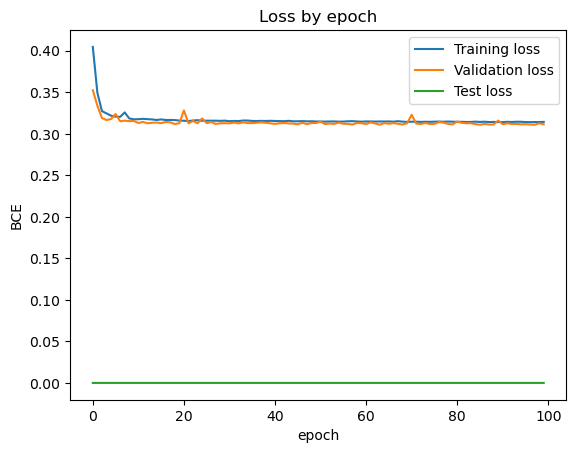

In [110]:
# Plotting the loss by epoch
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Training loss")
ax1.plot(valid_loss_by_epoch, label="Validation loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("BCE")

#### Training model With embeddings

In [111]:
# Verifying the length of user_id that will be used like embedding
len(user_id.unique())

5891

In [112]:
# Characteristics of the user_id feature
user_id.unique()

array([1000001, 1000002, 1000003, ..., 1004113, 1005391, 1001529])

In [113]:
# Verifyin the length of product_id that will be used like embedding
len(product_id.unique())

3631

In [114]:
# Characteristics of the product_id feature
product_id.unique()

array(['P00069042', 'P00248942', 'P00087842', ..., 'P00370293',
       'P00371644', 'P00370853'], dtype=object)

In [115]:
#Transform the user_id variable to use like embedding
user_id_to_idx = {value:i for i, value in enumerate(user_id.unique())}

In [116]:
#Transform the product_id variable to use like embedding
product_id_to_idx = {value:j for j, value in enumerate(product_id.unique())}

In [117]:
# Vectors of user_id and product_id on the dataset
user_idx = np.array([user_id_to_idx[value] for value in user_id])
product_idx = np.array([product_id_to_idx[value] for value in product_id])


In [118]:
# Splitting up the vector user_idx in training and validation
user_idx_train = user_idx[train_idx]
user_idx_validation = user_idx[valid_idx]

In [119]:
# Splitting up the vector product_idx in training and validation
product_idx_train = product_idx[train_idx]
product_idx_validation = product_idx[valid_idx]

In [120]:
# Class Dataset with embeddings
class DatasetWithEmbeddings(Dataset):

    def __init__(self, x, user_idx, product_idx, y) -> None:
        self.x = x
        self.user_idx = user_idx
        self.product_idx = product_idx
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index) -> Any:
        return self.x[index], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [121]:
train_df_embeddings = DatasetWithEmbeddings(train_x, user_idx_train, product_idx_train, train_y)
validation_df_embeddings = DatasetWithEmbeddings(valid_x, user_idx_validation, product_idx_validation, valid_y)

In [122]:
train_dataloader_embeddings = DataLoader(train_df_embeddings, batch_size=64, shuffle=True)
validation_dataloader_embeddings = DataLoader(validation_df_embeddings, batch_size=64)

### Architecture of the neural network with embeddings

In [123]:
class NNetworkWithEmbeddings(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embeddings_user = torch.nn.Embedding(num_embeddings=5891, embedding_dim=8)
    self.embeddings_product = torch.nn.Embedding(num_embeddings=3631, embedding_dim=8)
    self.linear_1 = torch.nn.Linear(in_features=29, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.output = torch.nn.Linear(in_features = 100, out_features= 1, bias=True)

  def forward(self, x, user_idx, product_idx):
    embeddings_outputs = self.embeddings(user_idx, product_idx)
    x = torch.cat([x, embeddings_outputs], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.output(x)
    return x